The goal of this notebook is analyze the cosine similarities of outputs of consecutive layers and see if we can build models to predict those similarities from input embeddings. The idea is that we can get rid of layers with high cosine similarity. Inspired by ["The Unreasonable Inefectiveness of the Deeper Layers"](https://arxiv.org/pdf/2403.17887v1)

In [1]:
from pathlib import Path
from typing import Callable, Optional
from dataclasses import dataclass

from opt_sim_dataset import OptSimilaritiesDataset

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import DataLoader, random_split

from tqdm.notebook import tqdm

In [2]:
data = OptSimilaritiesDataset(Path('./data'), 13, 100, 1)

In [3]:
def test_dataset(data: OptSimilaritiesDataset):
    X, Y, blocks = [], [], []
    first_sample_len = len(list(Path('./data/block0/0').iterdir())) 
    for idx in range(first_sample_len + 1):
        x, y, block = data[idx] 
        X.append(x)
        Y.append(y)
        blocks.append(block)

    x0 = torch.load('./data/block0/0/0.pt')
    assert torch.allclose(x0, X[0]), 'Wrong x values'
    assert blocks[0] == 0, 'Wrong block value'

    x1 = torch.load('./data/block0/0/1.pt')
    assert torch.allclose(x1, X[1]), 'Wrong x values'
    assert blocks[1] == 0, 'Wrong block value'

    x2 = torch.load('./data/block0/1/0.pt')
    assert torch.allclose(x2, X[first_sample_len]), 'Wrong x values'
    assert blocks[first_sample_len] == 0, 'Wrong block values'

    y0 = F.cosine_similarity(
        torch.load('./data/block1/0/0.pt'),
        torch.load(f'./data/block{data.n + 1}/0/0.pt'),
        dim=-1
    )
    assert torch.isclose(Y[0], y0), 'Wrong y values'

    y1 = F.cosine_similarity(
        torch.load('./data/block1/0/1.pt'),
        torch.load(f'./data/block{data.n + 1}/0/1.pt'),
        dim=-1
    )
    assert torch.isclose(Y[1], y1), 'Wrong y values'

    y2 = F.cosine_similarity(
        torch.load('./data/block1/1/0.pt'),
        torch.load(f'./data/block{data.n + 1}/1/0.pt'),
        dim=-1
    )
    assert torch.isclose(Y[first_sample_len], y2), 'Wrong y values'

test_dataset(data)
print('All tests passed')

All tests passed


In [4]:
@dataclass 
class MlpConfig:
    input_size: int
    output_size: int
    hidden_size: Optional[int] 

class LogReg(nn.Module):
    def __init__(self, config: MlpConfig):
        super(LogReg, self).__init__()
        self.fc = nn.Linear(config.input_size, config.output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x, *args):
        return self.sigmoid(self.fc(x))

class SimpleMLP(nn.Module):
    def __init__(self, config: MlpConfig):
        super(SimpleMLP, self).__init__()
        assert config.hidden_size is not None 

        self.fc1 = nn.Linear(config.input_size, config.hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(config.hidden_size, config.output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x, *args):
        # ignore args just to be compatible with PerBlockMlp
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

class PerBlockNet(nn.Module):
    def __init__(self, num_blocks: int, config: MlpConfig, block_net_cls: Callable[[MlpConfig], nn.Module]):
        super(PerBlockNet, self).__init__()
        self.num_blocks = num_blocks
        self.mlps = nn.ModuleList([block_net_cls(config) for _ in range(num_blocks)])
    
    def forward(self, x, blocks):
        out = torch.zeros(x.size(0))
        for idx, (xi, block) in enumerate(zip(x, blocks)):
            out[idx] = self.mlps[block](xi)
        
        return out.view(-1, 1) 

In [5]:
@torch.no_grad
def measure_loss(model, criterion, loader, device):
    model.eval()
    epoch_loss = 0
    for inputs, labels, blocks in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs, blocks).to(device)
        loss = criterion(outputs, labels)

        batch_size = outputs.numel()
        epoch_loss += loss.item() * batch_size / len(loader.dataset)

    return epoch_loss

In [6]:
x1 = torch.randn((768, 1)).to('cuda')
M1 = torch.randn((2048, 768)).to('cuda')
print((M1 @ x1).shape)
%timeit M1 @ x1 

torch.Size([2048, 1])
48.2 µs ± 212 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [7]:
x2 = torch.randn((768, 1)).to('cuda')
M2 = torch.randn((64, 768)).to('cuda')
print((M2 @ x2).shape)
%timeit M2 @ x2 

torch.Size([64, 1])
10.6 µs ± 347 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [8]:
def train_mlp(train_loader: DataLoader, val_loader: DataLoader, 
              model: SimpleMLP, criterion: Callable[[torch.Tensor, torch.Tensor], torch.Tensor], 
              num_epochs: int, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    for epoch in tqdm(range(num_epochs)):
        model.train()  
        epoch_loss = 0
        for inputs, labels, blocks in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            blocks = blocks.to(device)

            outputs = model(inputs, blocks).to(device)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_size = outputs.numel()
            epoch_loss += loss.item() * batch_size / len(train_loader.dataset)

        print(f'Epoch {epoch}: train_loss={epoch_loss:.4e}, val_loss={measure_loss(model, criterion, val_loader, device):.4e}') 
    
    return model

In [9]:
N = len(data)
test_len = int(N * 0.3)
train_and_val_data, test_data = random_split(data, [N - test_len, test_len])

batch_size = 16
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

config = MlpConfig(
    input_size=768,
    hidden_size=256,
    output_size=1
)

In [10]:
for train_ratio in [0.6]: # torch.linspace(0.1, 0.6, 6):
    train_len = int(N * train_ratio)
    train_data, val_data = random_split(train_and_val_data, [train_len, N - train_len - test_len])

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

    device = 'cuda'
    model = PerBlockNet(data.per_sample_len, config, SimpleMLP) 
    model = model.to(device)
    criterion = nn.MSELoss() 
    model = train_mlp(train_loader, val_loader, model, criterion, 4, device)

    print(f'{train_ratio=}, test loss = {measure_loss(model, criterion, test_loader, device):.4e}')

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 0: train_loss=6.0600e-03, val_loss=2.8993e-03
Epoch 1: train_loss=2.5431e-03, val_loss=2.1758e-03
Epoch 2: train_loss=1.3310e-03, val_loss=1.0050e-03
Epoch 3: train_loss=9.9638e-04, val_loss=9.7442e-04
train_ratio=0.6, test loss = 1.0305e-03


In [11]:
per_block = [[] for _ in range(data.per_sample_len)]

for inputs, labels, blocks in test_loader:
    inputs = inputs.to(device)
    outputs = model(inputs, blocks)
    for block, out in zip(blocks, outputs):
        per_block[block].append(out.item())

In [12]:
for idx, x in enumerate(per_block):
    print(idx, len(x))

0 1428
1 1472
2 1438
3 1450
4 1396
5 1424
6 1452
7 1436
8 1367
9 1539
10 1487


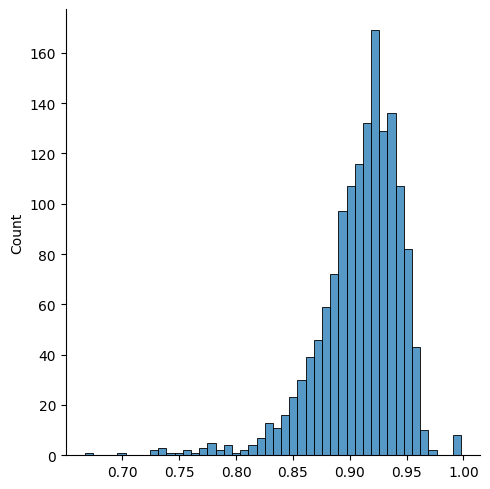

In [13]:
import seaborn as sns

sns.displot(per_block[-1])

In [14]:
simple_model = SimpleMLP(config).to(device)
train_mlp(train_loader, val_loader, simple_model, criterion, 4, device)
measure_loss(simple_model, criterion, test_loader, device)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 0: train_loss=2.6331e-03, val_loss=6.3583e-04
Epoch 1: train_loss=7.3194e-04, val_loss=5.4370e-04
Epoch 2: train_loss=6.6506e-04, val_loss=5.4538e-04
Epoch 3: train_loss=6.2904e-04, val_loss=4.9601e-04


0.0006667644149539702

In [15]:
per_block_simple = [[] for _ in range(data.per_sample_len)]

for inputs, labels, blocks in train_loader:
    inputs = inputs.to(device)
    outputs = simple_model(inputs, blocks)
    for block, out in zip(blocks, outputs):
        per_block_simple[block].append(out.item())

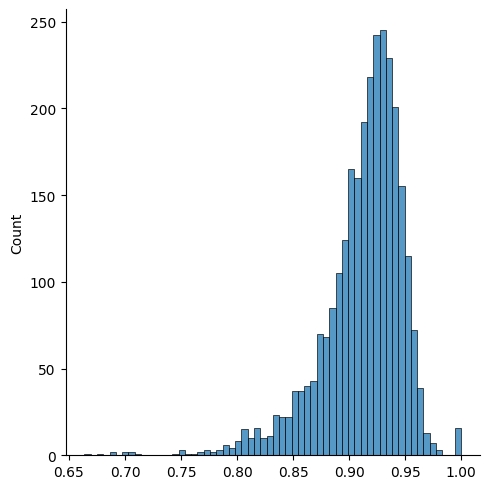

In [16]:
sns.displot(per_block_simple[-1])

In [17]:
per_block_actual = [[] for _ in range(data.per_sample_len)]
for _, y, blocks in train_loader:
    for block, sim in zip(blocks, y):
        per_block_actual[block].append(sim.item())

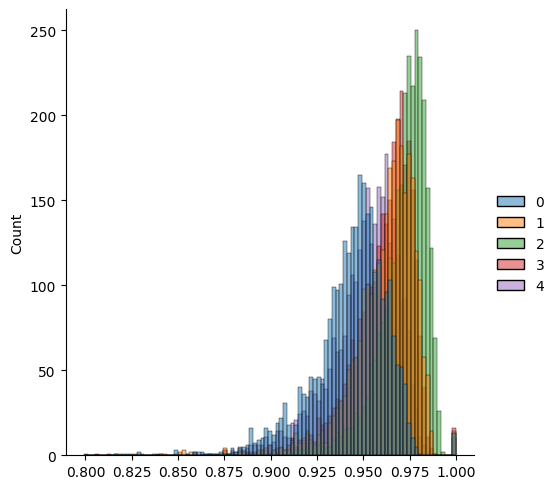

In [18]:
sns.displot(per_block_actual[:5]) 

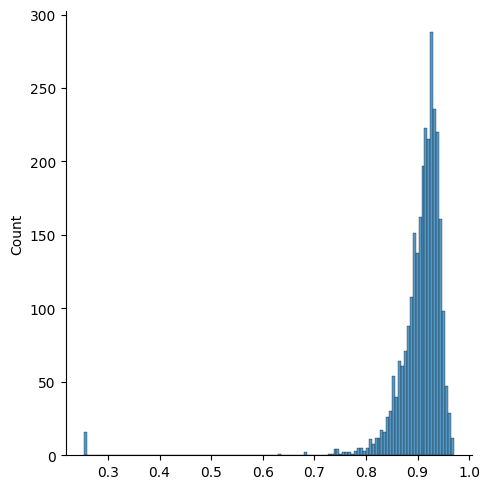

In [23]:
sns.displot(per_block_actual[-1])

In [20]:
for idx, x in enumerate(per_block_actual):
    print(idx, torch.tensor([x]).mean())

0 tensor(0.9432)
1 tensor(0.9612)
2 tensor(0.9714)
3 tensor(0.9601)
4 tensor(0.9503)
5 tensor(0.9489)
6 tensor(0.9475)
7 tensor(0.9331)
8 tensor(0.9221)
9 tensor(0.9286)
10 tensor(0.9050)


In [21]:
logreg = LogReg(config).to(device)
train_mlp(train_loader, val_loader, logreg, criterion, 4, device)
measure_loss(logreg, criterion, test_loader, device)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 0: train_loss=1.7942e-02, val_loss=3.3616e-03
Epoch 1: train_loss=2.5580e-03, val_loss=1.7350e-03
Epoch 2: train_loss=1.5278e-03, val_loss=1.1096e-03
Epoch 3: train_loss=1.1190e-03, val_loss=8.4586e-04


0.0010208853397538806

In [22]:
logreg_better = PerBlockNet(data.per_sample_len, config, LogReg).to(device)
train_mlp(train_loader, val_loader, logreg_better, criterion, 4, device)
measure_loss(logreg_better, criterion, test_loader, device)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 0: train_loss=2.6988e-02, val_loss=6.3124e-03
Epoch 1: train_loss=4.9658e-03, val_loss=4.8431e-03
Epoch 2: train_loss=4.3421e-03, val_loss=4.5968e-03
Epoch 3: train_loss=4.1972e-03, val_loss=4.4989e-03


0.0038762118848678718